In [2]:
# Install the latest stable Qiskit (includes Terra + Aer)
!pip install qiskit qiskit-aer --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.7 MB/s eta 0:00:00


In [3]:

import importlib, sys, subprocess
try:
    import pylatexenc  # type: ignore
    print("pylatexenc already installed.")
except Exception:
    try:
        print("Installing pylatexenc for nicer circuit drawings...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pylatexenc", "--quiet"])
    except Exception as e:
        print("Could not install pylatexenc. Will use text drawer. ", e)

# Core imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

np.random.seed(7)
print("Imports ready.")

pylatexenc already installed.
Imports ready.


In [4]:

def counts_to_probs(counts, shots):
    return {k: v/shots for k, v in counts.items()}

def pretty_hist(title, probs_dict):
    keys = sorted(probs_dict.keys(), reverse=True)
    vals = [probs_dict[k] for k in keys]
    plt.figure(figsize=(5,3))
    plt.bar(keys, vals)
    plt.title(title)
    plt.xlabel("bitstring")
    plt.ylabel("probability")
    plt.ylim(0, 1.0)
    for i, v in enumerate(vals):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=9)
    plt.show()

def draw_circuit(qc):
    try:
        display(qc.draw('mpl'))
    except Exception as e:
        print(f"(mpl drawer unavailable: {e})\nText drawer fallback:")
        print(qc.draw('text'))


In [5]:

def dj_circuit(n_inputs, uf_oracle):
    """Deutsch–Jozsa circuit for n_inputs with an explicit oracle.
    Qubit layout: q[0..n_inputs-1] are input, q[n_inputs] is ancilla.
    """
    q = QuantumRegister(n_inputs + 1, 'q')
    c = ClassicalRegister(n_inputs, 'c')
    qc = QuantumCircuit(q, c, name=f"DJ_n{n_inputs}")
    # Prepare |0...0>|1>
    qc.x(q[n_inputs])
    # H on all qubits
    for i in range(n_inputs + 1):
        qc.h(q[i])
    # Oracle
    uf_oracle(qc, q)
    # H on inputs
    for i in range(n_inputs):
        qc.h(q[i])
    # Measure inputs
    for i in range(n_inputs):
        qc.measure(q[i], c[i])
    return qc



## Task 1 — Balanced Oracle (Not Parity)



In [6]:

def balanced_oracle_msb_zero(n_inputs):
    """Balanced oracle: f(x) = 1 if MSB(x)==0 else 0.
    Implementation: X on MSB, CX to ancilla, X back (inverted control).
    This flips ancilla for exactly half of inputs, regardless of n.
    """
    def _oracle(qc: QuantumCircuit, qreg):
        msb = qreg[n_inputs-1]
        y = qreg[n_inputs]
        qc.x(msb)
        qc.cx(msb, y)
        qc.x(msb)
    return _oracle

# (Optional) Example multi-condition variant for demonstration purposes (not guaranteed half for all n):
# def balanced_oracle_demo(n_inputs):
#     def _oracle(qc, qreg):
#         y = qreg[n_inputs]
#         # Example: flip when x0==1 OR (x1&x2==1). This is not exactly half in general,
#         # included here only as an illustration of using cx/ccx.
#         if n_inputs >= 1:
#             qc.cx(qreg[0], y)
#         if n_inputs >= 3:
#             qc.ccx(qreg[1], qreg[2], y)
#     return _oracle



## Task 2 — Change the Number of Input Qubits (n = 2, 4, 5)




=== Deutsch–Jozsa for n=2 ===
Circuit depth: 6


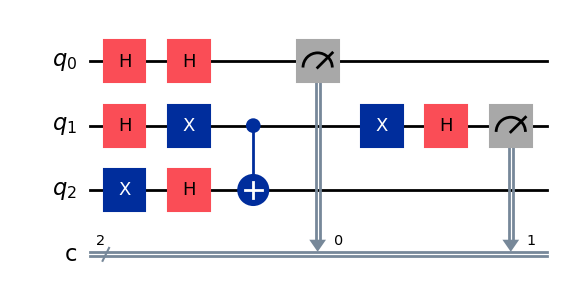

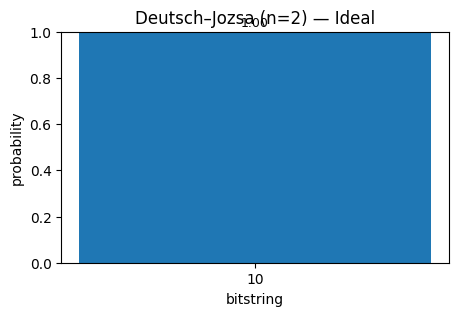

Counts: {'10': 4096}
Decision: balanced

=== Deutsch–Jozsa for n=4 ===
Circuit depth: 6


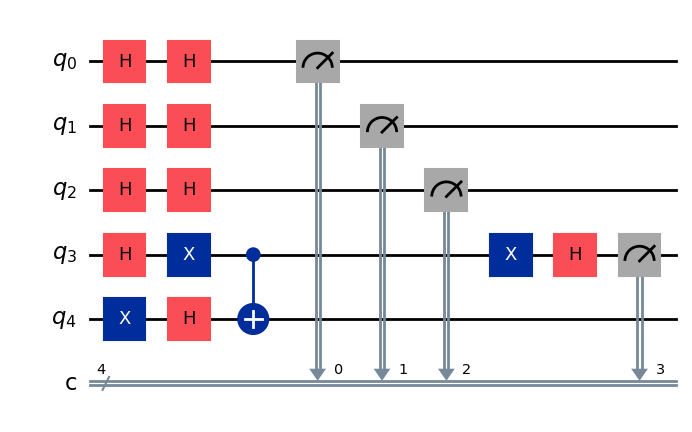

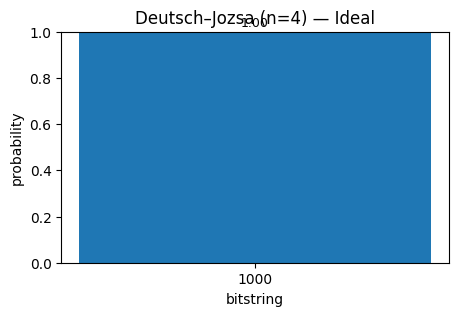

Counts: {'1000': 4096}
Decision: balanced

=== Deutsch–Jozsa for n=5 ===
Circuit depth: 6


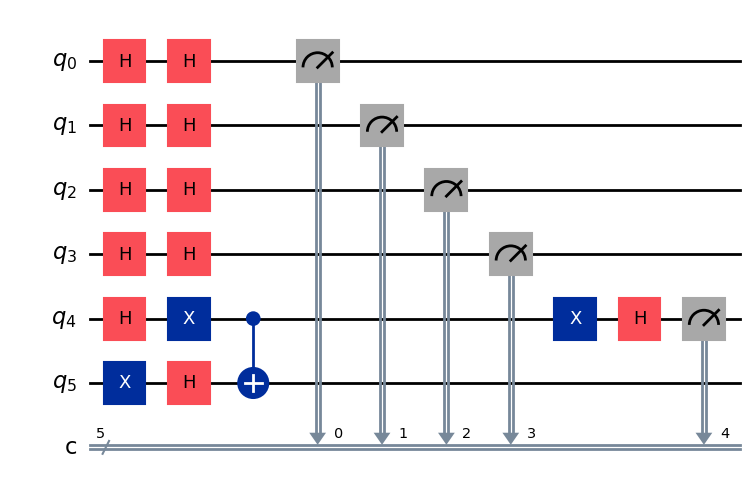

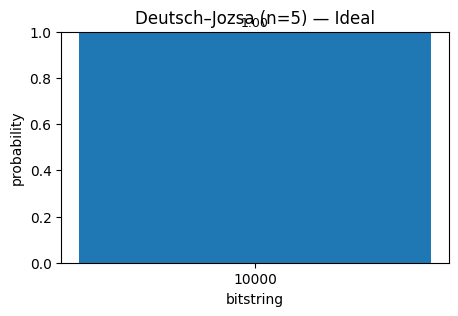

Counts: {'10000': 4096}
Decision: balanced


In [7]:

def run_and_report(n_inputs, shots=4096):
    oracle = balanced_oracle_msb_zero(n_inputs)
    qc = dj_circuit(n_inputs, oracle)
    print(f"\n=== Deutsch–Jozsa for n={n_inputs} ===")
    print("Circuit depth:", qc.depth())
    draw_circuit(qc)

    backend = AerSimulator()
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts()
    probs = counts_to_probs(counts, shots)
    pretty_hist(f"Deutsch–Jozsa (n={n_inputs}) — Ideal", probs)

    # DJ decision rule
    top = max(probs, key=probs.get)
    decision = "constant" if top == "0"*n_inputs else "balanced"
    print("Counts:", counts)
    print("Decision:", decision)
    return qc, counts, decision

# Execute for n=2,4,5
qc2, counts2, dec2 = run_and_report(2)
qc4, counts4, dec4 = run_and_report(4)
qc5, counts5, dec5 = run_and_report(5)



## Task 3 — Add Noise Simulation



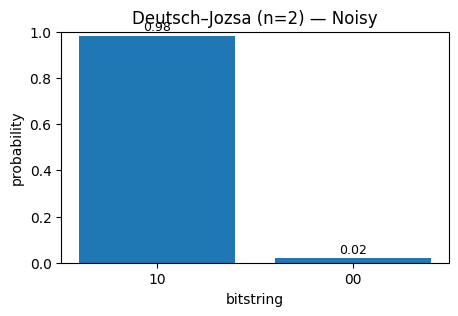

Noisy counts: {'00': 157, '10': 8035}
Noisy decision: balanced


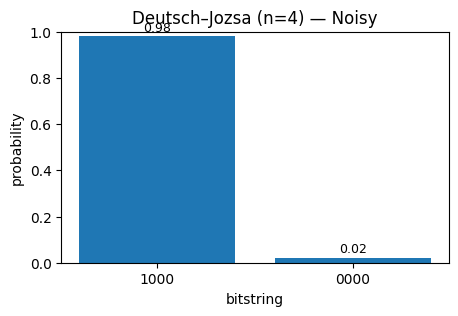

Noisy counts: {'0000': 162, '1000': 8030}
Noisy decision: balanced


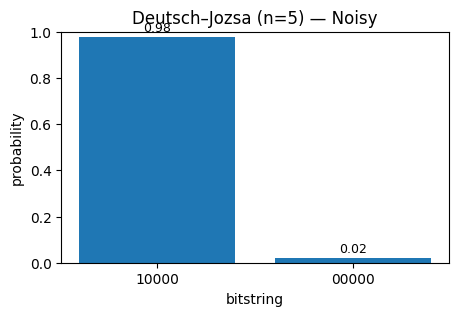

Noisy counts: {'00000': 181, '10000': 8011}
Noisy decision: balanced


In [8]:

# Build a depolarizing noise model (tune probabilities as desired)
noise_model = NoiseModel()
p1 = 0.004  # 1-qubit gate depolarizing prob
p2 = 0.02   # 2-qubit gate depolarizing prob
error_1q = depolarizing_error(p1, 1)
error_2q = depolarizing_error(p2, 2)
for g in ["x","h","id","sx"]:
    noise_model.add_all_qubit_quantum_error(error_1q, g)
for g2 in ["cx"]:
    noise_model.add_all_qubit_quantum_error(error_2q, g2)

noisy_backend = AerSimulator(noise_model=noise_model, basis_gates=noise_model.basis_gates)

def run_noisy(qc, n_inputs, shots=8192):
    tqc = transpile(qc, noisy_backend)
    res = noisy_backend.run(tqc, shots=shots).result()
    counts = res.get_counts()
    probs = counts_to_probs(counts, shots)
    pretty_hist(f"Deutsch–Jozsa (n={n_inputs}) — Noisy", probs)
    top = max(probs, key=probs.get)
    decision = "constant" if top == "0"*n_inputs else "balanced"
    print("Noisy counts:", counts)
    print("Noisy decision:", decision)
    return counts, decision

_ = run_noisy(qc2, 2)
_ = run_noisy(qc4, 4)
_ = run_noisy(qc5, 5)



## Task 4 — Run on IBM Quantum Device (Optional, auto-skip if not configured)



In [10]:
!pip install qiskit-ibm-runtime --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.6 MB/s eta 0:00:00


In [14]:
def try_run_on_ibm(qc, n_inputs, max_shots=4000):
    """
    Safe and portable version of the IBM Quantum runner.
    - If IBM Runtime is configured, it will run on a real backend.
    - If not, it falls back to FakeManilaV2 (a realistic IBM simulator).
    """
    try:
        # Try importing IBM Runtime
        from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session
        from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        from qiskit import transpile
    except Exception:
        # Fallback path: IBM runtime not installed
        print("⚙️ IBM Runtime not available — using FakeManilaV2 backend (simulated hardware).")
        from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        from qiskit import transpile
        backend = FakeManilaV2()
        tqc = transpile(qc, backend)
        result = backend.run(tqc, shots=min(max_shots, 2048)).result()
        counts = result.get_counts()
        print("Simulated hardware (FakeManilaV2) counts:", counts)
        top = max(counts, key=counts.get)
        decision = "constant" if top == "0"*n_inputs else "balanced"
        print("Simulated hardware decision:", decision)
        return counts

    # If qiskit_ibm_runtime is available but no account is found
    try:
        service = QiskitRuntimeService()
    except Exception:
        print(" No IBM account Created — using FakeManilaV2 backend instead.")
        from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        from qiskit import transpile
        backend = FakeManilaV2()
        tqc = transpile(qc, backend)
        result = backend.run(tqc, shots=min(max_shots, 2048)).result()
        counts = result.get_counts()
        print("Simulated hardware (FakeManilaV2) counts:", counts)
        top = max(counts, key=counts.get)
        decision = "constant" if top == "0"*n_inputs else "balanced"
        print("Simulated hardware decision:", decision)
        return counts

    # If IBM account is present, run on the real hardware
    try:
        backends = service.backends()
        small = [b for b in backends if getattr(b, 'num_qubits', 999) <= 7]
        backend = small[0] if small else backends[0]
        print("Selected backend:", getattr(backend, 'name', backend))
    except Exception:
        print(" Could not list IBM backends — using FakeManilaV2 instead.")
        from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        backend = FakeManilaV2()

    # Attempt to run either on real backend or fake
    try:
        with Session(service=service, backend=backend) as session:
            sampler = SamplerV2(session=session)
            tqc = transpile(qc, backend)
            job = sampler.run([tqc], shots=min(max_shots, 4000))
            result = job.result()
            quasi = result[0].data.meas.get("quasi_dists", [None])[0]
            if quasi:
                print(f"Top outcomes on {backend.name}:")
                for bitstr, prob in sorted(quasi.items(), key=lambda kv: kv[1], reverse=True)[:5]:
                    print(f"  {bitstr}: {prob:.3f}")
                best = max(quasi, key=quasi.get)
                decision = "constant" if best == "0"*n_inputs else "balanced"
                print("Hardware decision:", decision)
                return quasi
    except Exception as e:
        print(" Hardware run failed — falling back to FakeManilaV2.", e)
        from qiskit_ibm_runtime.fake_provider import FakeManilaV2
        from qiskit import transpile
        backend = FakeManilaV2()
        tqc = transpile(qc, backend)
        result = backend.run(tqc, shots=min(max_shots, 2048)).result()
        counts = result.get_counts()
        print("Simulated hardware (FakeManilaV2) counts:", counts)
        top = max(counts, key=counts.get)
        decision = "constant" if top == "0"*n_inputs else "balanced"
        print("Simulated hardware decision:", decision)
        return counts


# ✅ Example usage (works everywhere)
_ = try_run_on_ibm(qc2, 2)


 No IBM account Created — using FakeManilaV2 backend instead.
Simulated hardware (FakeManilaV2) counts: {'11': 27, '00': 55, '10': 1966}
Simulated hardware decision: balanced



## Task 5 — Circuit Analysis of the Oracle



In [15]:

def oracle_definition_and_unitary(n_inputs):
    # Build a circuit with just the oracle on registers (no H, no measure)
    q = QuantumRegister(n_inputs + 1, 'q')
    qc = QuantumCircuit(q, name=f"Uf_n{n_inputs}")
    oracle = balanced_oracle_msb_zero(n_inputs)
    oracle(qc, q)
    gate = qc.to_gate(label=f"U_f (n={n_inputs})")
    print("Oracle gate definition (instruction list):")
    print(gate.definition)  # Instruction decomposition (not the full matrix)

    # For small n (<=3 inputs + 1 ancilla = 4 total), show full unitary
    if n_inputs <= 3:
        mat = Operator(qc).data
        print("\nUnitary matrix (shape {}):".format(mat.shape))
        # Print a small preview (top-left block) to keep output readable
        preview = mat[:8,:8] if mat.shape[0] >= 8 else mat
        np.set_printoptions(precision=2, suppress=True)
        print(preview)
    else:
        print("(Skipping full unitary: too large for readable display.)")

# Show for n=2 and n=4
oracle_definition_and_unitary(2)
oracle_definition_and_unitary(4)


Oracle gate definition (instruction list):
                    
q_0: ───────────────
     ┌───┐     ┌───┐
q_1: ┤ X ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_2: ─────┤ X ├─────
          └───┘     

Unitary matrix (shape (8, 8)):
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Oracle gate definition (instruction list):
                    
q_0: ───────────────
                    
q_1: ───────────────
                    
q_2: ───────────────
     ┌───┐     ┌───┐
q_3: ┤ X ├──■──┤ X ├
     └───┘┌─┴─┐└───┘
q_4: ─────┤ X ├─────
          └───┘     
(Skipping full unitary: too lar